## Hesam Mohebi
Logistic Regression 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
import math

In [2]:
def mixGauss(means, sigmas, n):
    """
    means : 2D array (num_classes, d)
        Each row of the array gives the mean of the Gaussian in multiple dimensions for one class.
        For binary classification problems, the number of rows should be 2!
    sigmas : 1D array (num_classes)
        The standard deviation for the Gaussian distribution of each class (isotropic Gaussian!)
    
    Example:
    
    >>> means = [[3, 0], [0, 0]]
    >>> sigmas = [0.5, 1]
    >>> X, Y = mixGauss(means, sigmas, n=100)
    >>> fig, ax = plt.subplots()
    >>> ax.scatter(X[Y == 1,0], X[Y == 1,1], marker='o', color='r')
    >>> ax.scatter(X[Y == -1,0], X[Y == -1,1], marker='o', color='b')
    """
    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(
            mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2, size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

In [3]:
def flipLabels(Y, perc):
    if perc < 1 or perc > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * perc / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

In [4]:
def separatingFLR(Xtr, Ytr, Ypred, w):
    fig, ax = plt.subplots()
    xi = np.linspace(Xtr[:, 0].min(), Xtr[:, 0].max(), 200)
    yi = np.linspace(Xtr[:, 1].min(), Xtr[:, 1].max(), 200)
    X, Y = np.meshgrid(xi,yi)
    
    zi = griddata(Xtr, Ypred, (X,Y), method='linear')
    
    ax.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    ax.scatter(Xtr[:,0], Xtr[:,1], c=Ytr, marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(Xtr[:,0].min(), Xtr[:,0].max())
    ax.set_ylim(Xtr[:,1].min(), Xtr[:,1].max())

In [5]:
def optimal_gd_learning_rate(Xtr, reg_par):
    # Estimate the gamma parameter: the optimal learning rate for gradient descent
    eigvals = np.linalg.eigvalsh(Xtr.T @ Xtr)
    L = np.max(eigvals) / Xtr.shape[0] + 2 * reg_par
    gamma = 1 / L
    return gamma

In [6]:
def train_logreg_gd(Xtr, Ytr, reg_par, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    maxiter : the maximum number of gradient-descent iterations
    """
    # Epsilon is a criterion for early stopping
    epsilon = 1e-6
    
    # size of the input in the training
    n, D = np.shape(Xtr)
    
    # initialization of the vector w
    w = np.zeros((D, 1))
    
    # Set the learning rate optimally
    gamma = optimal_gd_learning_rate(Xtr, reg_par)
    
    # initialization of some supporting variables
    j=0
    loss_old = 0
    loss = float("inf")
    training_losses = np.zeros(maxiter + 1)
    Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1
    while j < maxiter and abs(loss - loss_old) >= epsilon:
        loss_old = loss
        # compute prediction using current weights 
        z = np.dot(Xtr, w)
        predictions = 1/(1+np.exp(-z))
        # calculating the gradient
        gradient = (1/n) * np.dot(Xtr.T, (predictions - Ytr)) + reg_par *w
        w = w - gamma * (gradient)
        loss = (-1 / n) * (np.dot(Ytr.T, np.log(predictions)) + np.dot((1 - Ytr).T, np.log(1 - predictions))) + (reg_par / 2) * np.sum(w**2)

        training_losses[j] = loss[0, 0]
        j = j + 1
    return w, training_losses[:j]


In [7]:
def predict_logreg(weights, X):
    """
    weights : array of shape d, 1
    X : array of shape n, d
    """
    ypred = np.dot(X, weights)
    # Try and understand what it does, deriving the formula
    ppred = 1 / (1 + np.exp(-ypred))
    # The outputs are reshaped to be 1D vectors.
    return ypred.reshape(-1), ppred.reshape(-1)

In [8]:
def calcError(Ypred, Y):
    class_err = np.mean(np.sign(Ypred) != Y)
    return class_err

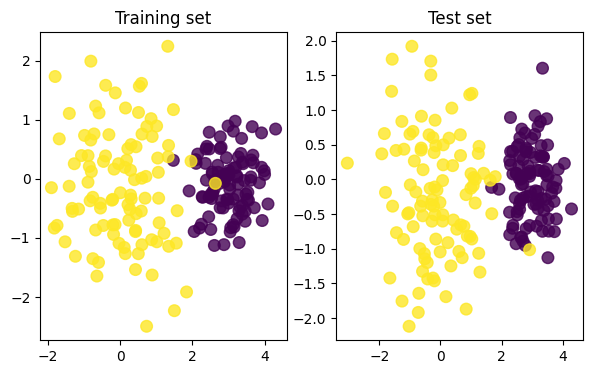

In [9]:
# Help for data-generation
means = [[3,0],[0,0]]
sigmas = [0.5, 1]

Xtr, Ytr = mixGauss(means, sigmas, n=100)
Xts, Yts = mixGauss(means, sigmas, n=100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

# TODO: Plot training and test sets, coloring the two classes differently.
fig = plt.figure(figsize=(7, 4))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

ax0.set_title("Training set")
ax0.scatter(Xtr[:,0], Xtr[:,1], s=70, c=Ytr, alpha=0.8)

ax1.set_title("Test set")
ax1.scatter(Xts[:,0], Xts[:,1], s=70, c=Yts, alpha=0.8)

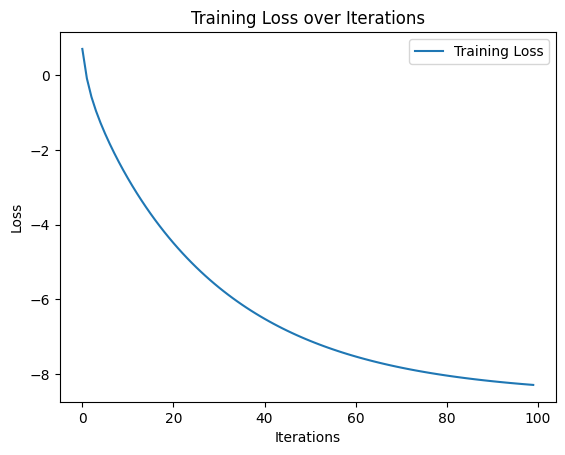

In [11]:
reg_par = 0.1  # Regularization parameter
maxiter = 100  # Maximum number of iterations

# Train the logistic regression model and get losses
w, training_losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par, maxiter=maxiter)

# Plot the training losses
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.show()


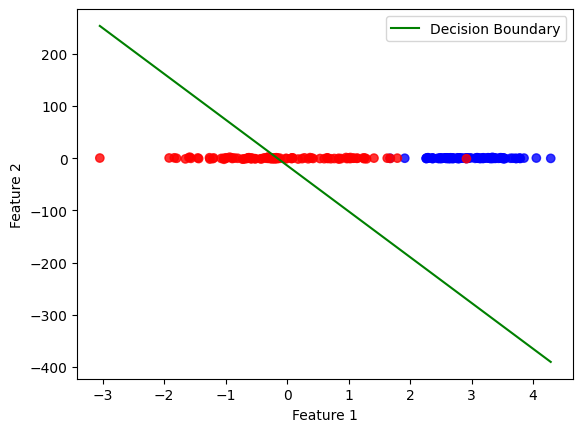

In [12]:
# Function to plot the decision boundary
def plot_decision_boundary(w, X, Y):
    # Scatter plot of the test set
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='bwr', alpha=0.8)

    # Calculate decision boundary points
    x_values = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    y_values = -(w[0] * x_values + w[2]) / w[1]  # Solves for x2 in terms of x1

    # Plot decision boundary line
    plt.plot(x_values, y_values, color='green', label="Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

# Call function to plot decision boundary on test set
plot_decision_boundary(w, Xts_wbias, Yts)


In [13]:
# Generate predictions for the training set
tr_pred, _ = predict_logreg(w, Xtr_wbias)
# Calculate training error
tr_err = np.mean((tr_pred >= 0.5) != (Ytr == 1))

# Generate predictions for the test set
ts_pred, _ = predict_logreg(w, Xts_wbias)
# Calculate test error
ts_err = np.mean((ts_pred >= 0.5) != (Yts == 1))

# Print errors
print("Training error: %.2f%%, Test error: %.2f%%" % (tr_err * 100, ts_err * 100))


Training error: 30.00%, Test error: 25.00%


In [14]:
def plot_logreg_confidence(X, Y, pred_confidence, threshold):
    """
    X : a (n, d) dataset
    Y : a (n, ) array of targets
    pred_confidence : A (n, ) array of probabilities predicted from X
    threshold : a float between 0 and 0.5 determining the probability threshold we use to 
                consider neutral predictions. For example if threshold=0.1 then all probabilities
                between 0.4 and 0.6 will be considered neutral (that is, neither belonging to class +1
                or to class -1).
    """
    fig, ax = plt.subplots()
    xi = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
    yi = np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
    X_grid, Y_grid = np.meshgrid(xi,yi)
    
    zi = griddata(X, pred_confidence, (X_grid, Y_grid), method='linear')
    
    ax.contour(xi, yi, zi, 15, linewidths=2, levels=[0.5 - threshold, 0.5 + threshold])
    
    # Plot data points
    ax.scatter(X[:,0], X[:,1], c=Y, 
               marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(X[:,0].min(), X[:,0].max())
    ax.set_ylim(X[:,1].min(), X[:,1].max())

In [15]:
# Generate some data
Xtr, Ytr = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)
Xts, Yts = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

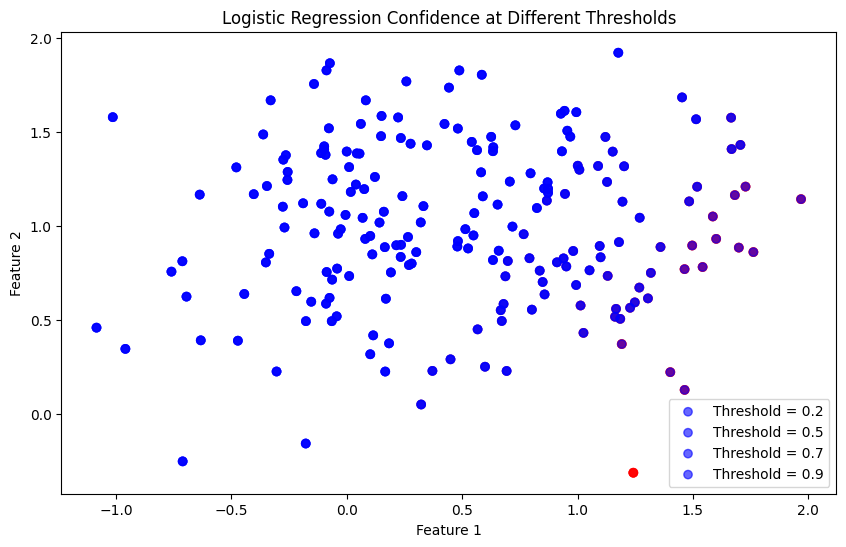

In [16]:
# Assuming `train_logreg_gd` and `predict_logreg` are defined as in previous code

# Set parameters
reg_par = 0.1  # Regularization parameter
maxiter = 100  # Maximum number of iterations

# Train the logistic regression model on the training set
w, _ = train_logreg_gd(Xtr_wbias, Ytr, reg_par, maxiter=maxiter)

# Obtain probability predictions for the test set
ts_pred, ts_conf = predict_logreg(w, Xts_wbias)

# Plotting confidence values for different thresholds
thresholds = [0.2, 0.5, 0.7, 0.9]
plt.figure(figsize=(10, 6))

for threshold in thresholds:
    predictions = (ts_conf >= threshold).astype(int)  # Apply threshold
    plt.scatter(Xts_wbias[:, 0], Xts_wbias[:, 1], c=predictions, cmap='bwr', alpha=0.6, label=f'Threshold = {threshold}')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Logistic Regression Confidence at Different Thresholds")
plt.show()


In [17]:
def calc_error_with_confidence(prob_pred, Y, threshold):
    """
    Calculate the classification error on only the predictions with a high confidence!
    """
    class_m1 = prob_pred <= 0.5 - threshold
    class_p1 = prob_pred > 0.5 + threshold
    
    err_class_m1 = Y[class_m1] != -1
    err_class_p1 = Y[class_p1] != 1
    return (np.sum(err_class_m1) + np.sum(err_class_p1)) / (len(err_class_m1) + len(err_class_p1))

Threshold: 0.5, High-confidence error: 0.00%
Threshold: 0.6, High-confidence error: 0.00%
Threshold: 0.7, High-confidence error: 0.00%
Threshold: 0.8, High-confidence error: 0.00%
Threshold: 0.9, High-confidence error: 0.00%


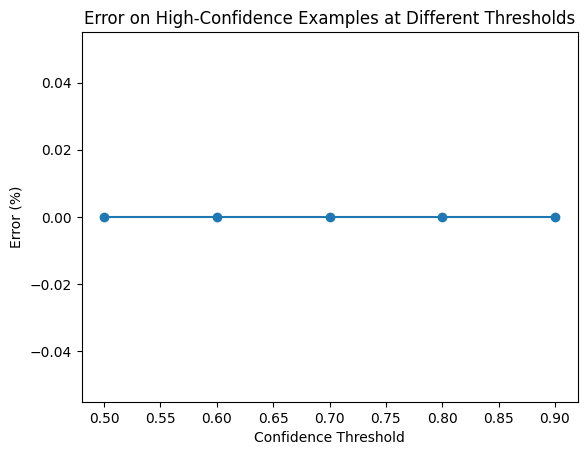

In [18]:
# Set parameters
reg_par = 0.1  # Regularization parameter
maxiter = 100  # Maximum number of iterations

# Train the logistic regression model on the training set
w, _ = train_logreg_gd(Xtr_wbias, Ytr, reg_par, maxiter=maxiter)

# Get predictions and confidence levels on the test set
ts_pred, ts_conf = predict_logreg(w, Xts_wbias)

# Define thresholds to evaluate high-confidence examples
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
errors = []

for threshold in thresholds:
    # Select high-confidence examples (confidence >= threshold)
    high_conf_indices = ts_conf >= threshold
    high_conf_predictions = (ts_conf[high_conf_indices] >= 0.5).astype(int)
    high_conf_labels = Yts[high_conf_indices]

    # Calculate error on high-confidence examples
    if len(high_conf_labels) > 0:
        error = np.mean(high_conf_predictions != (high_conf_labels == 1))
        errors.append((threshold, error))
    else:
        errors.append((threshold, None))  # No high-confidence examples at this threshold

# Display the errors at each threshold
for threshold, error in errors:
    if error is not None:
        print(f"Threshold: {threshold}, High-confidence error: {error * 100:.2f}%")
    else:
        print(f"Threshold: {threshold}, No high-confidence examples found")

# Optional: Plotting the error as a function of threshold
threshold_values, error_values = zip(*[(t, e) for t, e in errors if e is not None])
plt.plot(threshold_values, [e * 100 for e in error_values], marker='o')
plt.xlabel("Confidence Threshold")
plt.ylabel("Error (%)")
plt.title("Error on High-Confidence Examples at Different Thresholds")
plt.show()


In [ ]:
``